In [212]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder,StandardScaler
from sklearn.model_selection import train_test_split

# Stroke Risk Synthetic 2025

https://www.kaggle.com/datasets/imaadmahmood/stroke-risk-synthetic-2025/data

In [213]:
df = pd.read_csv('stroke_dataset.csv')
df.head()

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,1,Male,44,1,0,Yes,Private,Urban,136.71,29.10,never smoked,0
1,2,Female,15,0,0,Yes,Self-employed,Urban,77.12,27.01,formerly smoked,1
2,3,Female,55,0,0,Yes,Never_worked,Rural,141.59,22.63,never smoked,0
3,4,Female,72,0,0,Yes,Never_worked,Rural,128.37,14.59,smokes,0
4,5,Male,38,1,0,No,children,Rural,135.48,28.36,smokes,0


In [214]:
df['gender'] = df['gender'].map({'Male': 1, 'Female':0})
df['ever_married'] = df['ever_married'].map({'Yes': 1, 'No':0})
df['Residence_type'] = df['Residence_type'].map({'Rural': 1, 'Urban':0})
df.drop('id', axis=1, inplace=True)

,gender,age,hypertension,heart_disease,ever_married,Residence_type,avg_glucose_level,bmi,stroke
count,126.000000,126.000000,126.000000,126.000000,126.000000,126.000000,126.000000,126.000000,126.000000
mean,0.507937,46.722222,0.492063,0.126984,0.698413,0.492063,103.012381,25.208571,0.301587
std,0.501933,23.258767,0.501933,0.334284,0.460779,0.501933,24.284384,5.347856,0.460779
min,0.000000,5.000000,0.000000,0.000000,0.000000,0.000000,50.000000,13.050000,0.000000
25%,0.000000,28.250000,0.000000,0.000000,0.000000,0.000000,84.077500,21.707500,0.000000
50%,1.000000,44.000000,0.000000,0.000000,1.000000,0.000000,101.540000,25.355000,0.000000
75%,1.000000,58.750000,1.000000,0.000000,1.000000,1.000000,119.717500,29.077500,1.000000
max,1.000000,100.000000,1.000000,1.000000,1.000000,1.000000,163.010000,35.590000,1.000000


<Axes: >

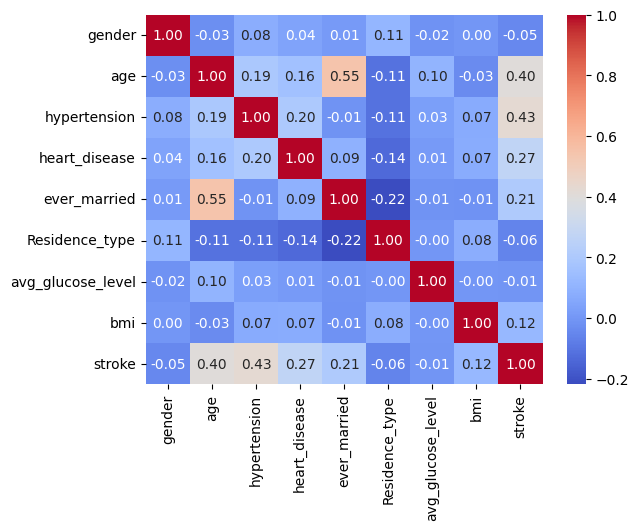

In [215]:
display(df.describe())
corr = df.corr(numeric_only=True)
sns.heatmap(corr, annot=True, cmap="coolwarm", fmt=".2f")

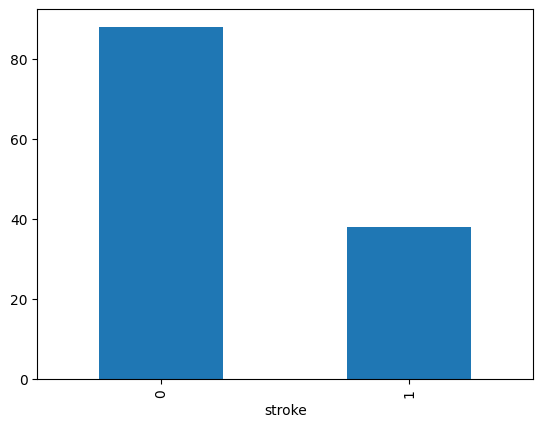

In [216]:
df['stroke'].value_counts().plot(kind='bar')
plt.show()

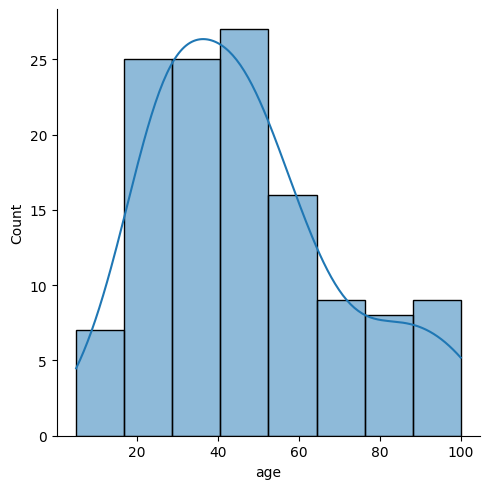

In [217]:
sns.displot(df['age'], kde=True)
plt.show()

In [236]:
X_train, X_test, y_train, y_test = train_test_split(df.drop('stroke', axis=1), df['stroke'], test_size=0.3, random_state=42)

preprocessor = ColumnTransformer(
    transformers=[
        ("onehot_work_type", OneHotEncoder(handle_unknown="ignore"), ["work_type"]),
        ("onehot_smoking_status", OneHotEncoder(handle_unknown="ignore"), ["smoking_status"]),
        ("std_avg_glucose_level", StandardScaler(), ["avg_glucose_level"]),
        ("std_bmi", StandardScaler(), ["bmi"])
    ]
)
preprocessor = preprocessor.fit(X_train)
#X_train = preprocessor.transform(X_train)
#X_test = preprocessor.transform(X_test)

X_train_transform = preprocessor.transform(X_train)
feature_names = preprocessor.get_feature_names_out()
X_train_transform = pd.DataFrame(X_train_transform, columns=feature_names,  index=X_train.index)
X_train = pd.concat([X_train_transform, X_train.drop(columns=['work_type','smoking_status','avg_glucose_level','bmi'])], axis=1)

X_test_transform = preprocessor.transform(X_test)
feature_names = preprocessor.get_feature_names_out()
X_test_transform = pd.DataFrame(X_test_transform, columns=feature_names,index=X_test.index)
X_test = pd.concat([X_test_transform, X_test.drop(columns=['work_type','smoking_status','avg_glucose_level','bmi'])], axis=1)

Acurácia: 0.6053%

Relatório de Classificação:
               precision    recall  f1-score   support

           0       0.61      1.00      0.75        23
           1       0.00      0.00      0.00        15

    accuracy                           0.61        38
   macro avg       0.30      0.50      0.38        38
weighted avg       0.37      0.61      0.46        38



/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


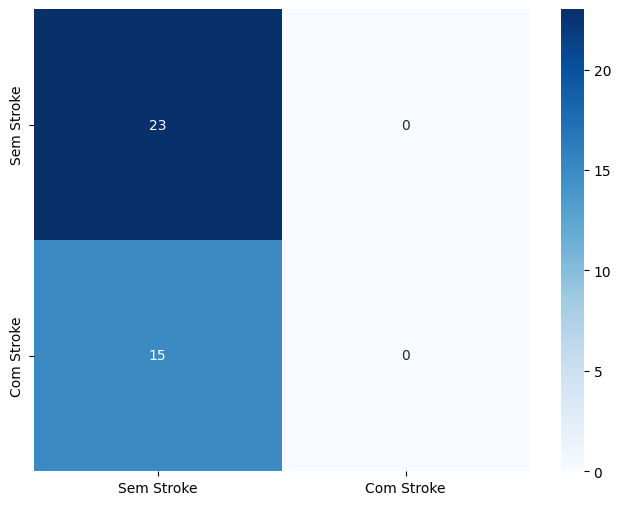

In [237]:
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report


model = XGBClassifier(
    n_estimators=100,        # número de árvores
    learning_rate=0.001,      # taxa de aprendizado
    max_depth=4,             # profundidade das árvores
    random_state=42,
)

# Treinar
model.fit(X_train, y_train)

# Prever
y_pred = model.predict(X_test)

# Avaliar
print(f"Acurácia: {accuracy_score(y_test, y_pred):.4f}%")
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Sem Stroke", "Com Stroke"], yticklabels=["Sem Stroke", "Com Stroke"])
print("\nRelatório de Classificação:\n", classification_report(y_test, y_pred))

Acurácia: 0.6053%

Relatório de Classificação:
               precision    recall  f1-score   support

           0       0.61      1.00      0.75        23
           1       0.00      0.00      0.00        15

    accuracy                           0.61        38
   macro avg       0.30      0.50      0.38        38
weighted avg       0.37      0.61      0.46        38



/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


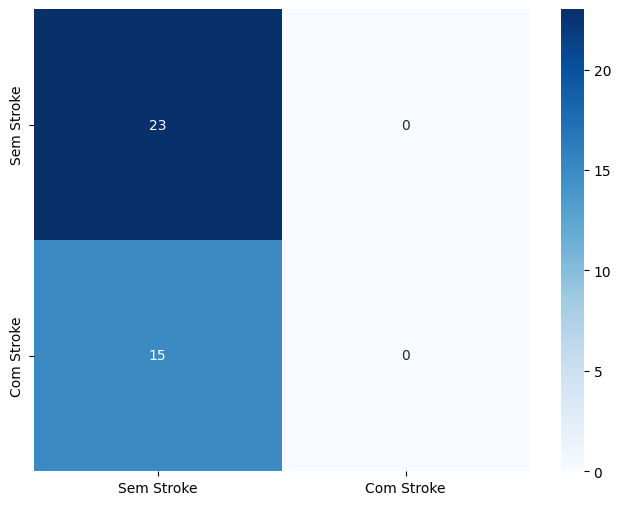

In [238]:
from sklearn.tree import DecisionTreeClassifier

model = DecisionTreeClassifier(
    criterion='gini',   # ou 'entropy'
    max_depth=2,        # limita profundidade (evita overfitting)
    min_samples_split=2,
    min_samples_leaf=1,
    random_state=42
)

model.fit(X_train, y_train)
print(f"Acurácia: {accuracy_score(y_test, y_pred):.4f}%")
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Sem Stroke", "Com Stroke"], yticklabels=["Sem Stroke", "Com Stroke"])
print("\nRelatório de Classificação:\n", classification_report(y_test, y_pred))


Acurácia: 0.6053%

Relatório de Classificação:
               precision    recall  f1-score   support

           0       0.61      1.00      0.75        23
           1       0.00      0.00      0.00        15

    accuracy                           0.61        38
   macro avg       0.30      0.50      0.38        38
weighted avg       0.37      0.61      0.46        38



/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


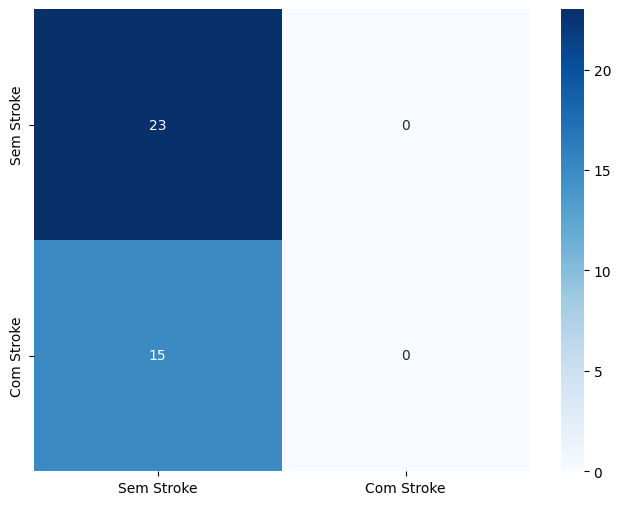

In [239]:
from sklearn.linear_model import LogisticRegression
model = LogisticRegression(max_iter=500, random_state=42)
model.fit(X_train, y_train)
print(f"Acurácia: {accuracy_score(y_test, y_pred):.4f}%")
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Sem Stroke", "Com Stroke"], yticklabels=["Sem Stroke", "Com Stroke"])
print("\nRelatório de Classificação:\n", classification_report(y_test, y_pred))




In [231]:
!pip install scikit-optimize

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 107.8/107.8 kB 3.2 MB/s eta 0:00:00


In [232]:
from skopt import gp_minimize
from skopt.space import Integer, Real, Categorical
from skopt.utils import use_named_args
from xgboost import XGBClassifier
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, StackingClassifier, VotingClassifier
from sklearn.svm import SVC

# Espaço de busca
space = [
    # RandomForest
    Integer(50, 200, name="n_estimators_rf"),
    Integer(2, 10, name="max_depth_rf"),

    # SVM
    Real(0.01, 10.0, name="C_svm"),
    Categorical(["linear", "rbf"], name="kernel_svm"),

    # XGBoost
    Integer(50, 200, name="n_estimators_xgb"),
    Real(0.01, 0.3, name="learning_rate_xgb"),
    Integer(2, 10, name="max_depth_xgb"),

    # Voting type
    Categorical(["soft", "hard"], name="voting_type")
]
# Função objetivo
@use_named_args(space)
def objective(**params):
    rf = RandomForestClassifier(
        n_estimators=params["n_estimators_rf"],
        max_depth=params["max_depth_rf"],
        random_state=42
    )

    svc = SVC(
        C=params["C_svm"],
        kernel=params["kernel_svm"],
        probability=True,  # necessário para voting="soft"
        random_state=42
    )

    xgb = XGBClassifier(
        n_estimators=params["n_estimators_xgb"],
        learning_rate=params["learning_rate_xgb"],
        max_depth=params["max_depth_xgb"],
        eval_metric="logloss",
        random_state=42
    )

    # Meta-modelo: Logistic Regression
    meta_lr = LogisticRegression(max_iter=1000, random_state=42)

    # Stacking (RF + SVM como base, LogisticRegression como meta-modelo)
    stacking = StackingClassifier(
        estimators=[("rf", rf), ("svc", svc),("xgb", xgb)],
        final_estimator=meta_lr,
        passthrough=True
    )

    # Voting (RF + SVM + XGB)
    voting = VotingClassifier(
        estimators=[("rf", rf), ("svc", svc), ("xgb", xgb)],
        voting=params["voting_type"]
    )

    # Avaliar ambos
    scores_stack = cross_val_score(stacking, X_train, y_train, cv=5, scoring="accuracy")
    scores_vote = cross_val_score(voting, X_train, y_train, cv=5, scoring="accuracy")

    # Combinação (50% stacking, 50% voting)
    return -(0.5 * np.mean(scores_stack) + 0.5 * np.mean(scores_vote))

# Rodar otimização
res = gp_minimize(objective, space, n_calls=40, random_state=42)

print("Melhor score combinado:", -res.fun)
print("Melhores hiperparâmetros:", res.x)
print("Nomeados:", dict(zip([dim.name for dim in space], res.x)))

Melhor score combinado: 0.7271241830065359
Melhores hiperparâmetros: [np.int64(50), np.int64(10), 0.01, np.str_('linear'), np.int64(50), 0.01, np.int64(10), np.str_('soft')]
Nomeados: {'n_estimators_rf': np.int64(50), 'max_depth_rf': np.int64(10), 'C_svm': 0.01, 'kernel_svm': np.str_('linear'), 'n_estimators_xgb': np.int64(50), 'learning_rate_xgb': 0.01, 'max_depth_xgb': np.int64(10), 'voting_type': np.str_('soft')}


Melhor score combinado: 0.7271241830065359
Melhores hiperparâmetros: [np.int64(50), np.int64(10), 0.01, np.str_('linear'), np.int64(50), 0.01, np.int64(10), np.str_('soft')]
Nomeados: {'n_estimators_rf': np.int64(50), 'max_depth_rf': np.int64(10), 'C_svm': 0.01, 'kernel_svm': np.str_('linear'), 'n_estimators_xgb': np.int64(50), 'learning_rate_xgb': 0.01, 'max_depth_xgb': np.int64(10), 'voting_type': np.str_('soft')}


In [246]:
# Modelos base
model1 = RandomForestClassifier(n_estimators=50,max_depth=5, random_state=42)
model2 = GradientBoostingClassifier(n_estimators=50,learning_rate=0.01,max_depth=5, random_state=42)
model3 = SVC(C=0.01,probability=True, kernel="linear", random_state=42)

# Meta-modelo para stacking
meta_model = LogisticRegression()

# ----- STACKING -----
stacking_clf = StackingClassifier(
    estimators=[("rf", model1), ("gb", model2), ("svc", model3)],
    final_estimator=meta_model,
    cv=5
)

stacking_clf.fit(X_train, y_train)
y_pred_stack = stacking_clf.predict(X_test)

print("Stacking Accuracy:", accuracy_score(y_test, y_pred_stack))
print(classification_report(y_test, y_pred_stack))

# ----- VOTING -----
voting_clf = VotingClassifier(
    estimators=[("rf", model1), ("gb", model2), ("svc", model3)],
    voting="soft"
)

voting_clf.fit(X_train, y_train)
y_pred_vote = voting_clf.predict(X_test)

print("Voting Accuracy:", accuracy_score(y_test, y_pred_vote))

# Avaliação em treino e teste
y_train_pred = voting_clf.predict(X_train)
y_test_pred = voting_clf.predict(X_test)

acc_train = accuracy_score(y_train, y_train_pred)
acc_test = accuracy_score(y_test, y_test_pred)

print(f"Voting Ensemble - Acurácia Treino: {acc_train:.4f}")
print(f"Voting Ensemble - Acurácia Teste:  {acc_test:.4f}")

# Detectando overfitting
if acc_train - acc_test > 0.05:
    print("⚠️ Possível Overfitting (diferença > 5%)")
else:
    print("✅ Sem sinais fortes de overfitting")

# ----- MATRIZ DE CONFUSÃO -----
cm = confusion_matrix(y_test, y_pred_vote)
print("\nMatriz de Confusão (Voting):")
print(cm)

# ----- CLASSIFICATION REPORT -----
print("\nClassification Report (Voting):")
print(classification_report(y_test, y_pred_vote))

Stacking Accuracy: 0.7105263157894737
              precision    recall  f1-score   support

           0       0.68      1.00      0.81        23
           1       1.00      0.27      0.42        15

    accuracy                           0.71        38
   macro avg       0.84      0.63      0.61        38
weighted avg       0.80      0.71      0.65        38

Voting Accuracy: 0.7631578947368421
Voting Ensemble - Acurácia Treino: 0.8636
Voting Ensemble - Acurácia Teste:  0.7632
⚠️ Possível Overfitting (diferença > 5%)

Matriz de Confusão (Voting):
[[23  0]
 [ 9  6]]

Classification Report (Voting):
              precision    recall  f1-score   support

           0       0.72      1.00      0.84        23
           1       1.00      0.40      0.57        15

    accuracy                           0.76        38
   macro avg       0.86      0.70      0.70        38
weighted avg       0.83      0.76      0.73        38



In [222]:
from tensorflow import keras
from tensorflow.keras import layers

y_train = keras.utils.to_categorical(y_train,num_classes=2)
y_test = keras.utils.to_categorical(y_test,num_classes=2)

In [223]:
input_dim = X_train.shape[1]

model = keras.Sequential([
    keras.Input(shape=(input_dim,)),
    layers.Dense(48, activation="relu"),
    layers.Dense(32, activation="relu"),
    layers.Dense(32, activation="relu"),
    layers.Dense(2, activation="softmax")
])

In [224]:
from tensorflow.keras.callbacks import EarlyStopping

early_stop = EarlyStopping(monitor="val_loss",patience=10,restore_best_weights=True)
optimizer = keras.optimizers.Adam(learning_rate=0.00001)
model.compile(optimizer=optimizer,loss="categorical_crossentropy",metrics=["accuracy"])

model.fit(X_train,y_train,epochs=500,batch_size=2,validation_data=(X_test,y_test),callbacks=[early_stop],verbose=1)

Epoch 1/500
44/44 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.2501 - loss: 0.8580 - val_accuracy: 0.3947 - val_loss: 0.7683
Epoch 2/500
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.2022 - loss: 0.8826 - val_accuracy: 0.3947 - val_loss: 0.7653
Epoch 3/500
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.3236 - loss: 0.8120 - val_accuracy: 0.3947 - val_loss: 0.7624
Epoch 4/500
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.2819 - loss: 0.8270 - val_accuracy: 0.3947 - val_loss: 0.7595
Epoch 5/500
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.3216 - loss: 0.8072 - val_accuracy: 0.3947 - val_loss: 0.7568
Epoch 6/500
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.2820 - loss: 0.8260 - val_accuracy: 0.3947 - val_loss: 0.7541
Epoch 7/500
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.2762 - loss: 0.8016 - val_accuracy: 0.3947 - val_loss: 0.7514
Epoch 8/500
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.3011 - loss: 0.8164 - val_accuracy: 0.3947 - v

In [225]:
loss, acc = model.evaluate(X_test,y_test)
print(f"Acurácia no teste: {acc*100:.2f}%")

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.5910 - loss: 0.6712 
Acurácia no teste: 60.53%
